# Homework 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 1

> Choose one very good feature from the data set you used for Problem Set 1, and train a Gaussian Process to predict the labels based on that one feature. Use a Matern 3/2 kernel to begin, plus a diagonal (identity or delta-function) kernel. This model should have three free parameters (Matern amplitude sigma-squared, Matern width rho, identity amplitude). Predict the labels using this Gaussian process, 27 times, setting the values of the three parameters to [3., 0.3, 0.03], [1., 0.1, 0.01], and [0.1, 0.01, 0.001]. 
> 
> *Before you start, re-scale both the features X and labels Y you are using so they have zero mean and unit variance. That scaling should be done on the train, validation, and test data all treated as one data set. That is, all X data should be scaled with the same offset and scale, and all Y data should be scaled with the same offset and scale.*

## Part (0)

### Data prepping

Let's kick this off by loading the data maker from the first homework.

In [2]:
def make_data(seed=17, N=2**12, M=2**16, tiny=0.1):
    rng = np.random.default_rng(seed)
    latent_y = rng.uniform(size=N)
    X = rng.normal(size=(N, M)) + tiny * rng.normal(size=M)[None, :] ** 3 * latent_y[:, None] ** 1.5
    scales, shifts = 100. * rng.normal(size=M) ** 3, 100. * rng.normal(size=M) ** 3
    X *= scales[None, :]
    X += shifts[None, :]
    Y = latent_y + 0.02 * rng.normal(size=N)
    si = np.argsort(Y)
    return X[si], Y[si]

X, Y = make_data()
N, M = X.shape
assert(len(Y) == N)

Next, let's do the rescaling. Every feature and the labels should have zero mean, unit variance.

In [3]:
X = (X - X.mean(0)) / X.std(0)
Y = (Y - Y.mean()) / Y.std()

All that remains is to split the data into train/val/test sets. Borrowing my code from the first homework,

In [4]:
rng = np.random.default_rng(1126)
idx = rng.permutation(N)

X_tr, Y_tr = X[ idx[:2048] ],     Y[ idx[:2048] ]
X_va, Y_va = X[ idx[2048:3072] ], Y[ idx[2048:3072] ]
X_te, Y_te = X[ idx[3072:] ],     Y[ idx[3072:] ]

And now let's pick the best features so we can use the best (1) or (8) for our analysis.

In [5]:
pearson = np.zeros(M)
for i in range(M):
    pearson[i] = np.corrcoef(X_tr[:, i], Y_tr)[0, 1]
best_feats = np.argsort(np.abs(pearson))[::-1]

Best feature indices:
[42301 27727 48766 36678 44849 37418 18800 53003]


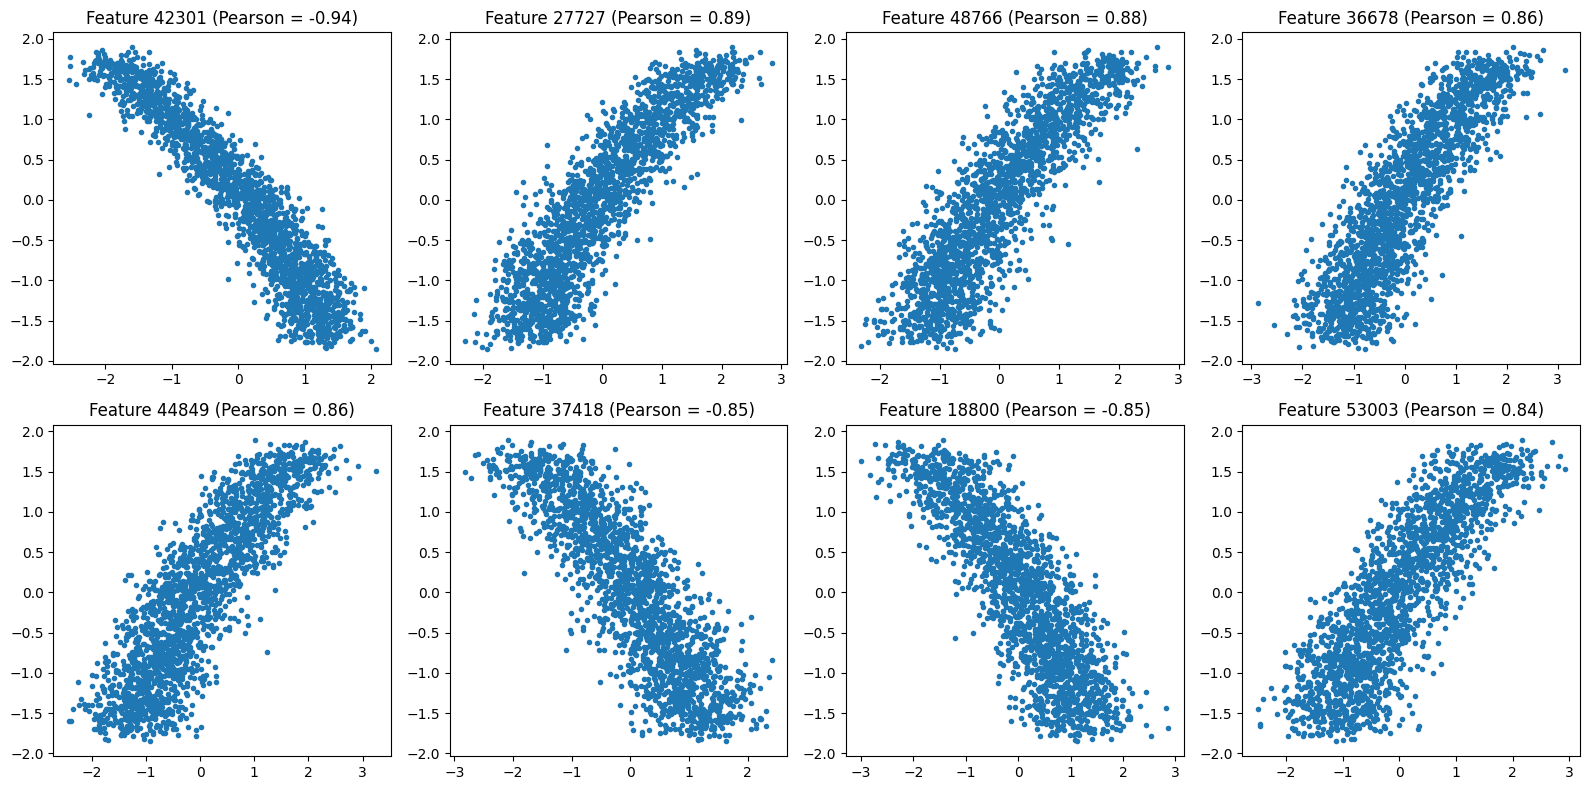

In [6]:
print('Best feature indices:')
print(best_feats[:8])

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axs.flat):
    f = best_feats[i]
    ax.plot(X_tr[:, f], Y_tr, '.')
    ax.set_title(f"Feature {f} (Pearson = {pearson[f]:.2f})")
fig.tight_layout()
plt.show()

### Rolling our own Gaussian process

In [7]:
ROOT_3 = np.sqrt(3)

def matern_3_2(x1, x2, sigma_sq=1, rho=1):
    # adapted from https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function#Simplification_for_%CE%BD_half_integer
    d = (x1 - x2) * ROOT_3 / rho
    return sigma_sq * (1 + d) * np.exp(- d)

def identity(x1, x2, amplitude=1):
    return (x1 == x2).astype(np.float64) * amplitude

def k(x1, x2, sigma_sq=1, rho=1, I_amp=1):
    return matern_3_2(x1, x2, sigma_sq, rho) + identity(x1, x2, amplitude=I_amp)

def k_matrix(X1, X2=None, **hyperparams):
    if X2 is None:
        X2 = X1
    return k(X1[:, None], X2[None, :], **hyperparams)

class GaussianProcess:
    def __init__(self, sigma_sq=1, rho=1, I_amp=1):
        self.hyperparams = dict(sigma_sq=sigma_sq, rho=rho, I_amp=I_amp)
        
    def fit(self, X, Y):
        self.X = X
        self.K = k_matrix(self.X, **self.hyperparams)
        self.Y = Y
        return self
        
    def predict_mean(self, X_star):
        K_star = k_matrix(X_star, self.X, **self.hyperparams)
        return K_star @ np.linalg.lstsq(self.K, self.Y, rcond=None)[0]
    
    def predict_variance(self, X_star):
        K_star = k_matrix(X_star, self.X, **self.hyperparams)
        K_2star = k_matrix(X_star, **self.hyperparams)
        return K_2star - K_star @ np.linalg.lstsq(self.K, K_star.T, rcond=None)[0]

In [8]:
# pick one feature
_x_tr = X_tr[:, best_feats[0]]
_x_va = X_va[:, best_feats[0]]

gp = GaussianProcess().fit(_x_tr, Y_tr)
mu = gp.predict_mean(_x_va)
var = gp.predict_variance(_x_va)

In [9]:
print(var.shape)
print(np.linalg.eigvalsh(var))

(1024, 1024)
[-26427862.67096343  -1215723.32316369   -650453.81899975 ...
    510169.72749629    661610.20590961   1198166.06503537]


Not all positive...

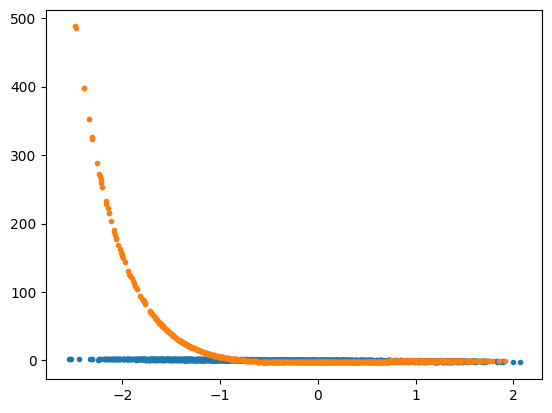

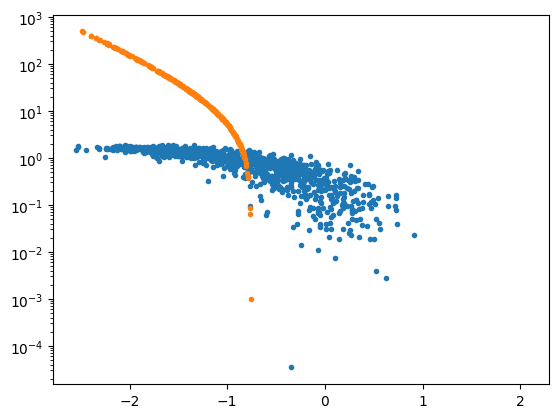

In [10]:
plt.plot(_x_tr, Y_tr, '.')
plt.plot(_x_va, mu, '.')
plt.show()

plt.plot(_x_tr, Y_tr, '.')
plt.plot(_x_va, mu, '.')
plt.yscale('log')
plt.show()

???

This is really bad.

### Giving up

Would a canned implementation work instead?

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel

def make_gp(sigma_sq=1.0, rho=1.0, I_amp=1.0):
    return GaussianProcessRegressor(
        kernel = ConstantKernel(sigma_sq, 'fixed') * Matern(rho, 'fixed'),
        alpha = I_amp  # "Value added to the diagonal of the kernel matrix during fitting"
    )

In [12]:
gp = make_gp().fit(_x_tr.reshape(-1, 1), Y_tr)
mu, std = gp.predict(_x_va.reshape(-1, 1), return_std=True)

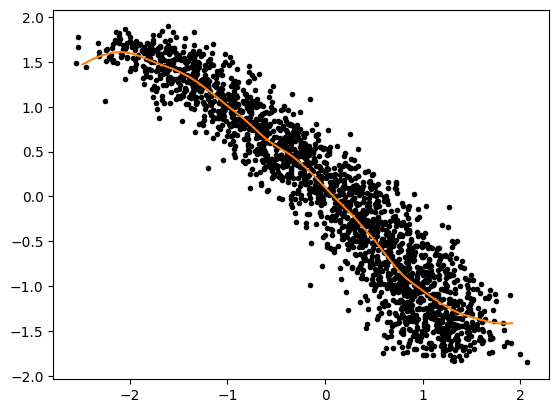

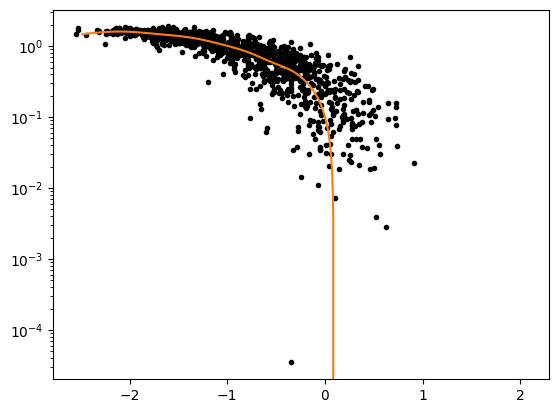

In [13]:
plt.plot(_x_tr, Y_tr, 'k.')
idx = np.argsort(_x_va)
plt.plot(_x_va[idx], mu[idx], '-', color='C1')
plt.show()

plt.plot(_x_tr, Y_tr, 'k.')
plt.plot(_x_va[idx], mu[idx], '-', color='C1')
plt.yscale('log')
plt.show()

I mean, this looks considerably better, so let's just use this instead.

### Training the models

In [14]:
class Experiment:
    def __init__(self, sigma_sq, rho, I_amp):
        self.sigma_sq = sigma_sq
        self.rho = rho
        self.I_amp = I_amp
        
        self.model = make_gp(sigma_sq, rho, I_amp)
        self.model.fit(_x_tr.reshape(-1, 1), Y_tr)
        
        self.pred_mean, self.pred_std = self.model.predict(_x_va.reshape(-1, 1), return_std=True)
        self.val_mse = np.square(self.pred_mean - Y_va).mean()

In [15]:
sigma_sq_vals = [3., 0.3, 0.03]
rho_vals = [1., 0.1, 0.01]
I_amp_vals = [0.1, 0.01, 0.001]

experiments = [
    Experiment(sigma_sq, rho, I_amp)
    for sigma_sq in sigma_sq_vals
    for rho in rho_vals
    for I_amp in I_amp_vals
]

## Part (a)

> What setting of the hyperparameters gave the highest probability to the training data?

From lecture, the log probability of the data given the model is

$$
\ln p = - \tfrac{1}{2} (y - \mu)^T V^{-1} (y - \mu) - \tfrac{1}{2} \ln (\det V)
$$

In [16]:
def log_prob(exp, eps=1e-10):
    mu, V = exp.model.predict(_x_tr.reshape(-1, 1), return_cov=True)
    V += eps * np.eye(len(V))
    sign, log_det_V = np.linalg.slogdet(V)
    assert sign == +1
    residual = (Y_tr - mu).reshape((-1, 1))
    return -0.5 * (residual.T @ np.linalg.lstsq(V, residual, None)[0] + log_det_V).squeeze()

Let's start by making a table of the log-probabilities.

In [17]:
fmt = "{: >8}  {: >8}  {: >8}  {: >8}"
print(fmt.format("sigma-sq", "rho", "I_amp", "log(p)"))
probs = []
for exp in experiments:
    prob = log_prob(exp)
    print(fmt.format(
        exp.sigma_sq,
        exp.rho,
        exp.I_amp,
        f"{prob:.3e}",
    ))
    probs.append(prob)

sigma-sq       rho     I_amp    log(p)
     3.0       1.0       0.1  -1.383e+11
     3.0       1.0      0.01  -1.383e+11
     3.0       1.0     0.001  -1.383e+11
     3.0       0.1       0.1  -9.197e+09
     3.0       0.1      0.01  -9.198e+09
     3.0       0.1     0.001  -9.197e+09
     3.0      0.01       0.1  -8.167e+07
     3.0      0.01      0.01  -8.166e+07
     3.0      0.01     0.001  -8.164e+07
     0.3       1.0       0.1  -2.801e+11
     0.3       1.0      0.01  -2.801e+11
     0.3       1.0     0.001  -2.801e+11
     0.3       0.1       0.1  -2.562e+10
     0.3       0.1      0.01  -2.562e+10
     0.3       0.1     0.001  -2.562e+10
     0.3      0.01       0.1  -4.173e+08
     0.3      0.01      0.01  -4.173e+08
     0.3      0.01     0.001  -4.172e+08
    0.03       1.0       0.1  -4.790e+11
    0.03       1.0      0.01  -4.790e+11
    0.03       1.0     0.001  -4.790e+11
    0.03       0.1       0.1  -6.233e+10
    0.03       0.1      0.01  -6.233e+10
    0.03       0.1

Tables are dumb, so let's make a plot instead.

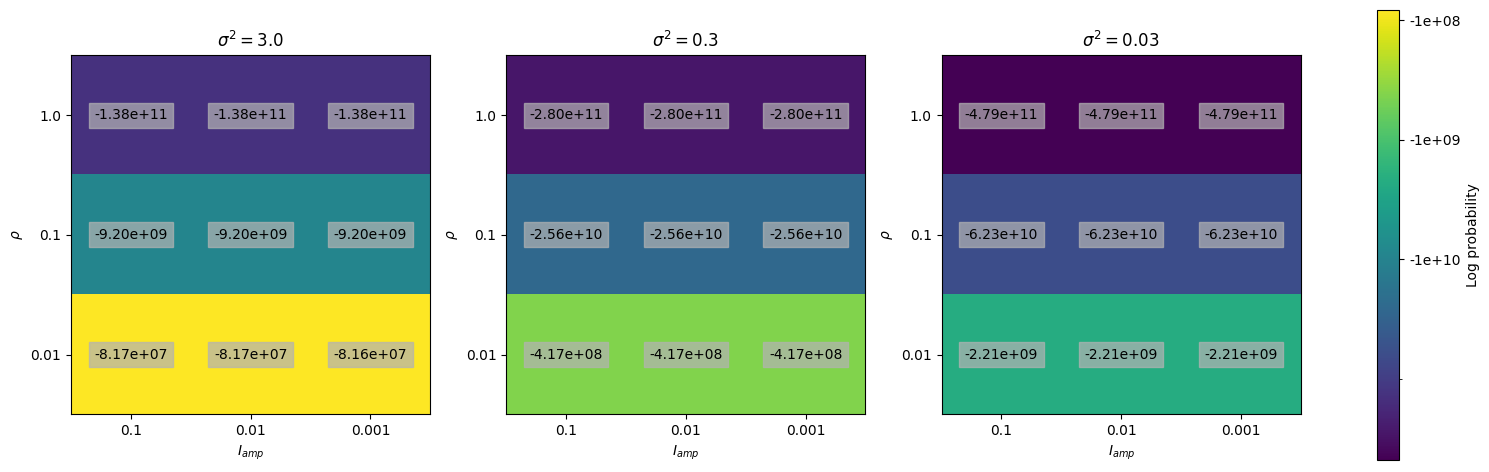

In [18]:
# First repack into an array
probs = np.array(probs)
probs = probs.reshape((3,3,3))

# and make convenience arrays that tell us the experiment values in 3x3x3 indices
rho_mesh, sigma_sq_mesh, I_amp_mesh = np.meshgrid(rho_vals, sigma_sq_vals, I_amp_vals)

# Now we can make a plot
from matplotlib.colors import SymLogNorm
from matplotlib.cm import ScalarMappable

norm = SymLogNorm(1e-1, vmin=probs.min(), vmax=probs.max())

fig, axs = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw=dict(width_ratios=[8,8,8,0.5]))

for i, ax in zip(range(3), axs.flat):
    im = ax.imshow(probs[i], cmap='viridis', norm=norm)
    
    for r in range(3):
        for c in range(3):
            ax.text(c, r, f"{probs[i,r,c]:.2e}", ha='center', va='center', backgroundcolor=(0.7,0.7,0.7,0.7))
            
    ax.set_xlabel('$I_{amp}$')
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(I_amp_vals)
    
    ax.set_ylabel('$\\rho$')
    ax.set_yticks([0,1,2])
    ax.set_yticklabels(rho_vals)
    
    ax.set_title('$\\sigma^2 = ' + f'{ sigma_sq_vals[i] }$')
    
cb = fig.colorbar(ScalarMappable(norm=norm, cmap='viridis'), cax=axs[-1])
cb.set_label('Log probability')
ticks = cb.get_ticks()[1:-1]
cb.set_ticks(ticks)
cb.set_ticklabels([f"{x:.0e}" for x in ticks])
    
fig.tight_layout()
plt.show()

The best probabilities here come from $\sigma^2 = 3$, $\rho = 0.01$, and almost any value of the regularization.

## Part (b)

> What setting of the hyperparameters gave the most accurate MSE to the validation data?

Let's start by making a table of MSE values.

In [19]:
fmt = "{: >8}  {: >8}  {: >8}  {: >8}"
print(fmt.format("sigma-sq", "rho", "I_amp", "MSE_val"))
for exp in experiments:
    print(fmt.format(
        exp.sigma_sq,
        exp.rho,
        exp.I_amp,
        f"{exp.val_mse:.1f}"
    ))

sigma-sq       rho     I_amp   MSE_val
     3.0       1.0       0.1       0.1
     3.0       1.0      0.01       0.1
     3.0       1.0     0.001       0.1
     3.0       0.1       0.1       0.1
     3.0       0.1      0.01       0.1
     3.0       0.1     0.001       0.1
     3.0      0.01       0.1       0.2
     3.0      0.01      0.01       0.2
     3.0      0.01     0.001       0.3
     0.3       1.0       0.1       0.1
     0.3       1.0      0.01       0.1
     0.3       1.0     0.001       0.1
     0.3       0.1       0.1       0.1
     0.3       0.1      0.01       0.1
     0.3       0.1     0.001       0.1
     0.3      0.01       0.1       0.2
     0.3      0.01      0.01       0.2
     0.3      0.01     0.001       0.2
    0.03       1.0       0.1       0.1
    0.03       1.0      0.01       0.1
    0.03       1.0     0.001       0.1
    0.03       0.1       0.1       0.1
    0.03       0.1      0.01       0.1
    0.03       0.1     0.001       0.1
    0.03      0.01       

Tables are dumb, so let's make a plot instead.

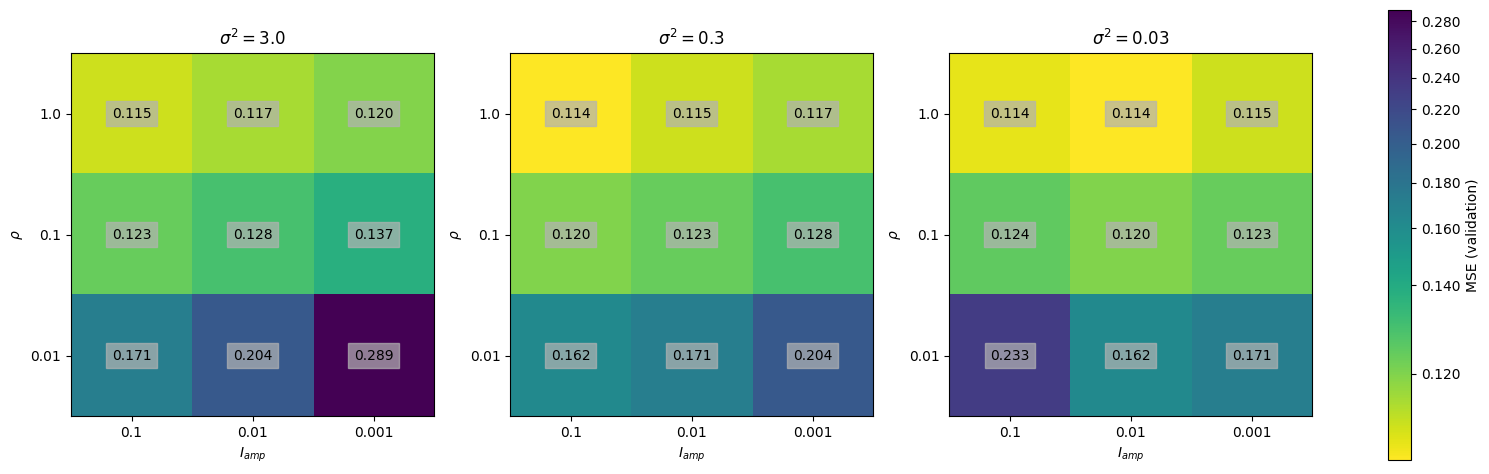

In [20]:
# First repack into an array
mses = np.array([exp.val_mse for exp in experiments])
mses = mses.reshape((3,3,3))

# and make convenience arrays that tell us the experiment values in 3x3x3 indices
rho_mesh, sigma_sq_mesh, I_amp_mesh = np.meshgrid(rho_vals, sigma_sq_vals, I_amp_vals)

# Now we can make a plot
from matplotlib.colors import PowerNorm
from matplotlib.cm import ScalarMappable

norm = PowerNorm(0.5, vmin=mses.min(), vmax=mses.max())

fig, axs = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw=dict(width_ratios=[8,8,8,0.5]))

for i, ax in zip(range(3), axs.flat):
    im = ax.imshow(mses[i], cmap='viridis_r', norm=norm)
    
    for r in range(3):
        for c in range(3):
            ax.text(c, r, f"{mses[i,r,c]:.3f}", ha='center', va='center', backgroundcolor=(0.7,0.7,0.7,0.7))
            
    ax.set_xlabel('$I_{amp}$')
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(I_amp_vals)
    
    ax.set_ylabel('$\\rho$')
    ax.set_yticks([0,1,2])
    ax.set_yticklabels(rho_vals)
    
    ax.set_title('$\\sigma^2 = ' + f'{ sigma_sq_vals[i] }$')
    
cb = fig.colorbar(ScalarMappable(norm=norm, cmap='viridis_r'), cax=axs[-1])
cb.set_label('MSE (validation)')
ticks = cb.get_ticks()[1:-1]
cb.set_ticks(ticks)
cb.set_ticklabels([f"{x:.3f}" for x in ticks])
    
fig.tight_layout()
plt.show()

So it looks like the best performing combination is $\sigma^2 = 0.3$, $\rho = 1$, and $I_{amp} = 0.1$, or, equally good, $\sigma^2 = 0.03$, $\rho = 1$, and $I_{amp} = 0.01$. 

In fact, it seems like there's a degeneracy between $\sigma^2$ and $I_{amp}$, since whole _columns_ of values are exactly preserved between these subplots, just shifted by one order of magnitude in $I_{amp}$ when $\sigma^2$ is shifted by an order of magnitude.

This set of values is close to what we might have initially guessed: a large value of $\rho$ to wash out the noisey high-frequency variations in the data, combined with a middling value of $\sigma^2$ and reasonably large regularization ($I_{amp}$) to give a _smooth_ fit, which we would guess generalizes best.

Weirdly, it looks like the MSEs are _inversely_ correlated with the probabilities, since the best probabilities are where we see some of our worst MSE values.

## Part (c)

> Make 27 x 2 plots of the mean and variance of the prediction as a continuous line (finely sampled line). Make 2 plots for every one of the 27 parameters: One zoomed out, showing a range wider than the full label range, and one zoomed in, showing a small fraction of the label range, showing the details of the predictions at small scales. Share your favorite plots on discord.

Plotted below:
- Validation data (labels vs single feature)
- Gaussian process mean prediction and one-sigma errorbars (solid blue line: mean prediction, semi-transparent blue region: one-sigma error region)

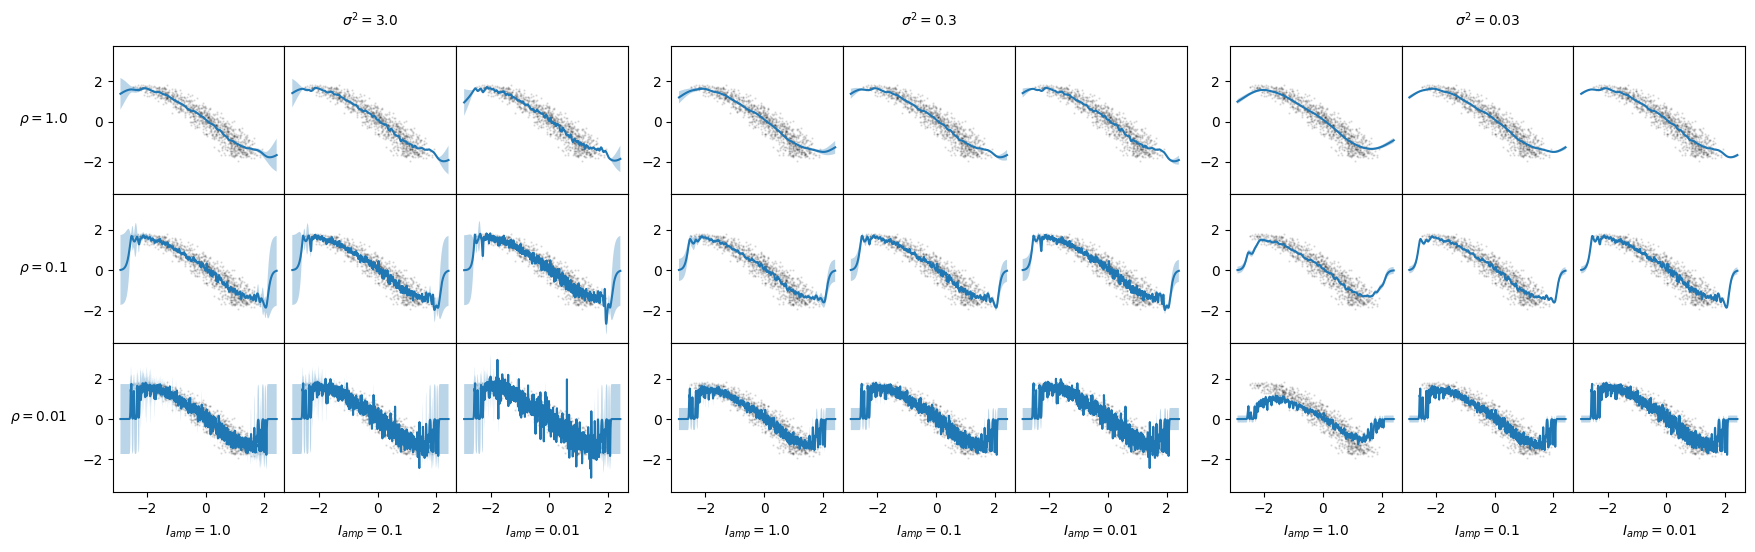

In [21]:
fig = plt.figure(figsize=(17, 5))

def make_width_ratios(size=8, gap=2):
    return [size] * 3 + [gap] + [size] * 3 + [gap] + [size] * 3

gs = fig.add_gridspec(3, 9 + 2, width_ratios=make_width_ratios(gap=2))

x_vals = np.linspace(_x_tr.min() - 0.35, _x_tr.max() + 0.35, 1_001)

y_lims = (None, None)

axs = np.empty((3, 3, 3), dtype=object)
for i in range(3):
    for r in range(3):
        for c in range(3):
            ax = fig.add_subplot(gs[r, c + 4 * i])
            axs[i,r,c] = ax
            
            exp = experiments[i * 9 + r * 3 + c]
            
            pred_mean, pred_std = exp.model.predict(x_vals.reshape(-1, 1), return_std=True)
            
            ax.scatter( _x_va, Y_va, s=0.5, alpha=0.1, color='k' )
            
            ax.plot(x_vals, pred_mean)
            ax.fill_between(x_vals, pred_mean - pred_std, pred_mean + pred_std, alpha=0.3)
            
            if y_lims[0] is None:
                y_lims = ax.get_ylim()
            else:
                y_lims = ( min(y_lims[0], ax.get_ylim()[0]), max(y_lims[1], ax.get_ylim()[1]) )
            
            # pedantry about tick marks
            if not (c == 0):
                ax.set_yticks([])
                
            if not (r == 2):
                ax.set_xticks([])
                
                
for i in range(3):
    for r in range(3):
        for c in range(3):
            axs[i,r,c].set_ylim(y_lims)
            
            
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(3):
    fig.text(
        (axs[i, 0, 0].get_position().xmin + axs[i, 0, 2].get_position().xmax) / 2,
        1.01,
        f"$\\sigma^2 = {sigma_sq_vals[i]}$",
        ha='center', va='baseline'
    )
    
    fig.text(
        0.,
        (axs[0, i, 0].get_position().ymin + axs[0, i, 0].get_position().ymax) / 2,
        f"$\\rho = {rho_vals[i]}$",
        ha='right', va='center'
    )
    
    for j in range(3):
        fig.text(
            (axs[j, -1, i].get_position().xmin + axs[j, -1, i].get_position().xmax) / 2,
            -0.01,
            "$I_{amp} = " + f"{rho_vals[i]}$",
            ha='center', va='baseline'
        )
            
plt.show()

And now let's do the same but on a narrower subset, near $x \in [-0.1, +0.1]$.

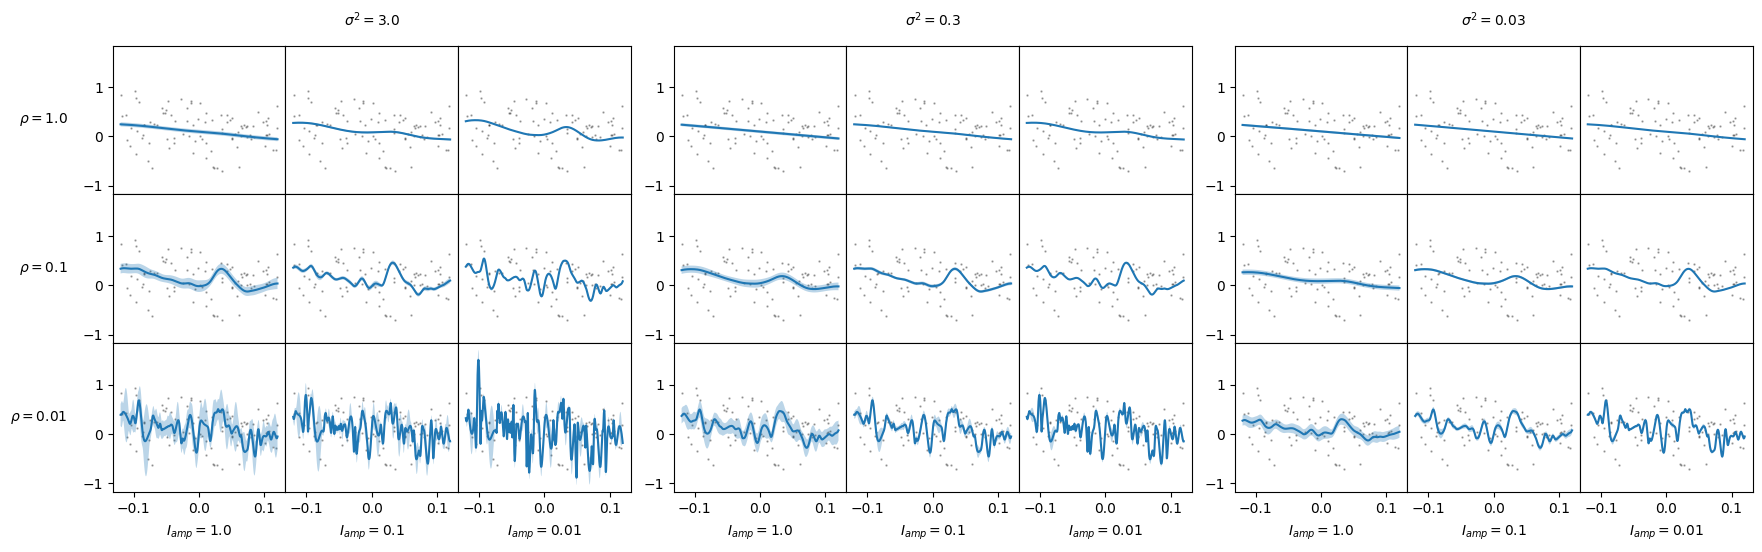

In [22]:
fig = plt.figure(figsize=(17, 5))

def make_width_ratios(size=8, gap=2):
    return [size] * 3 + [gap] + [size] * 3 + [gap] + [size] * 3

gs = fig.add_gridspec(3, 9 + 2, width_ratios=make_width_ratios(gap=2))

xlim = 0.12

x_vals = np.linspace(-xlim, +xlim, 1_001)

y_lims = (None, None)

axs = np.empty((3, 3, 3), dtype=object)
for i in range(3):
    for r in range(3):
        for c in range(3):
            ax = fig.add_subplot(gs[r, c + 4 * i])
            axs[i,r,c] = ax
            
            exp = experiments[i * 9 + r * 3 + c]
            
            pred_mean, pred_std = exp.model.predict(x_vals.reshape(-1, 1), return_std=True)
            
            ax.scatter( _x_va[(_x_va > -xlim) & (_x_va < +xlim)], Y_va[(_x_va > -xlim) & (_x_va < +xlim)], s=0.5, alpha=0.3, color='k' )
            
            ax.plot(x_vals, pred_mean)
            ax.fill_between(x_vals, pred_mean - pred_std, pred_mean + pred_std, alpha=0.3)
            
            if y_lims[0] is None:
                y_lims = ax.get_ylim()
            else:
                y_lims = ( min(y_lims[0], ax.get_ylim()[0]), max(y_lims[1], ax.get_ylim()[1]) )
            
            # pedantry about tick marks
            if not (c == 0):
                ax.set_yticks([])
                
            if not (r == 2):
                ax.set_xticks([])
                
                
for i in range(3):
    for r in range(3):
        for c in range(3):
            axs[i,r,c].set_ylim(y_lims)
            
            
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(3):
    fig.text(
        (axs[i, 0, 0].get_position().xmin + axs[i, 0, 2].get_position().xmax) / 2,
        1.01,
        f"$\\sigma^2 = {sigma_sq_vals[i]}$",
        ha='center', va='baseline'
    )
    
    fig.text(
        0.,
        (axs[0, i, 0].get_position().ymin + axs[0, i, 0].get_position().ymax) / 2,
        f"$\\rho = {rho_vals[i]}$",
        ha='right', va='center'
    )
    
    for j in range(3):
        fig.text(
            (axs[j, -1, i].get_position().xmin + axs[j, -1, i].get_position().xmax) / 2,
            -0.01,
            "$I_{amp} = " + f"{rho_vals[i]}$",
            ha='center', va='baseline'
        )
            
plt.show()

## Part (d)

> Now train and evaluate a GP (re-do parts a and b) using not one feature but 8 features. What additional decisions do you have to make and how did you make them?

In [23]:
_x_tr_8 = X_tr[:, best_feats[:8]]
_x_va_8 = X_va[:, best_feats[:8]]

gp = make_gp(0.3, np.sqrt(8), 0.1).fit( _x_tr_8, Y_tr )
pred_mean, pred_std = gp.predict( _x_va_8, return_std=True )

val_mse = np.square(pred_mean - Y_va).mean()
print(val_mse)

0.04538199120964218


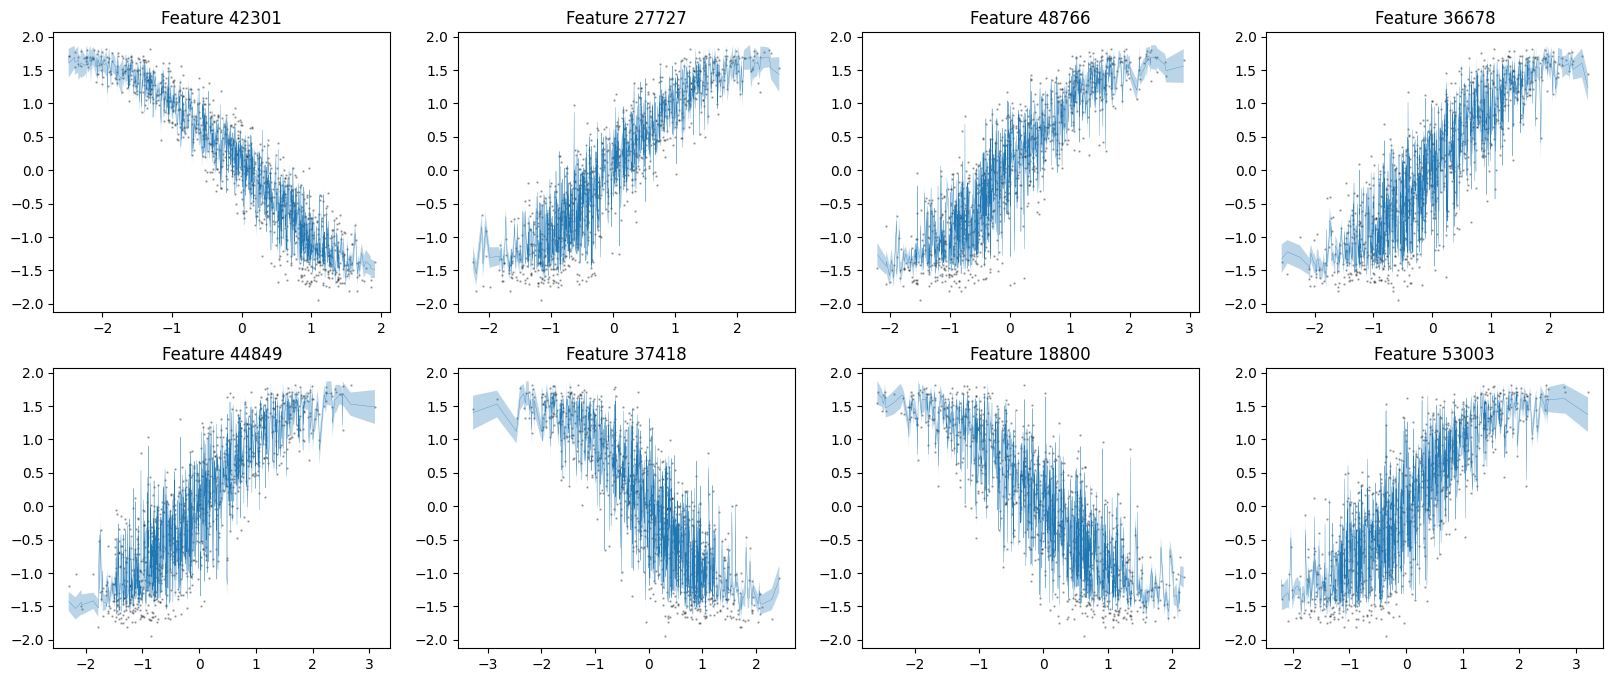

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

for i, ax in enumerate(axs.flat):
    ax.scatter(_x_va_8[:, i], Y_va, s=0.5, alpha=0.3, color='k')
    
    idx = np.argsort(_x_va_8[:, i])
    ax.plot(_x_va_8[idx, i], pred_mean[idx], lw=0.2)
    ax.fill_between(_x_va_8[idx, i], pred_mean[idx] - pred_std[idx], pred_mean[idx] + pred_std[idx], alpha=0.3)
    
    ax.set_title(f"Feature {best_feats[i]}")
    
plt.show()

The biggest choice to make is which values to give the hyperparameters.

For this, I decided to start with the values they got in the last section, and to scale the length scale ($\rho$) by a factor of $\sqrt{8}$ to account for the increase in dimensionality.

Interestingly, these predictions are _far_ more erratic than predictions for similar hyperparameter values before. This behavior persisted even when I played with the hyperparameter values, and I never achieved much better performance, so I didn't change it. I believe this is entirely due to the increase in dimensions — what _is_ a smooth prediction in multiple dimensions, and what are the relevant length scales? Surely the answers to these questions are different than for 1D.

Then, the MSE we obtain is already a factor of 2 better than the best MSE we got before.